In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle competitions download -c thai-handwritten-characters-recognition

100% 205M/205M [00:09<00:00, 25.0MB/s]
100% 205M/205M [00:09<00:00, 22.2MB/s]


In [ ]:
!unzip /content/thai-handwritten-characters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/65/Set3_M1_P-0089_201.jpg  
  inflating: train/train/65/Set3_M1_P-0090_203.jpg  
  inflating: train/train/65/Set3_M1_P-0091_200.jpg  
  inflating: train/train/65/Set3_M1_P-0092_172.jpg  
  inflating: train/train/65/Set3_M1_P-0093_179.jpg  
  inflating: train/train/65/Set3_M1_P-0093_198.jpg  
  inflating: train/train/65/Set3_M1_P-0094_170.jpg  
  inflating: train/train/65/Set3_M1_P-0095_174.jpg  
  inflating: train/train/65/Set3_M1_P-0096_170.jpg  
  inflating: train/train/65/Set3_M1_P-0097_170.jpg  
  inflating: train/train/65/Set3_M1_P-0098_170.jpg  
  inflating: train/train/65/Set4_F1_P-0001_168.jpg  
  inflating: train/train/65/Set4_F1_P-0002_169.jpg  
  inflating: train/train/65/Set4_F1_P-0003_170.jpg  
  inflating: train/train/65/Set4_F1_P-0003_190.jpg  
  inflating: train/train/65/Set4_F1_P-0004_167.jpg  
  inflating: train/train/65/Set4_F1_P-0004_198.jpg  
  inflating: train/train/65/Set4_F1_P-0005_171.j

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.4 MB/s eta 0:00:00


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.0 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob as gb
import seaborn as sns
import albumentations as A
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, Recall
import timm
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader ,random_split

In [ ]:
traindir = "/content/train/train/"

In [ ]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Grayscale(num_output_channels=1),
     transforms.RandomAutocontrast(0.2),
     ThresholdTransform(thr_255=220)
     ])

In [ ]:
image_dataset = datasets.ImageFolder(traindir, transform=transform)

In [ ]:
labels_map = image_dataset.class_to_idx

In [ ]:
class_names = image_dataset.classes

In [ ]:
n_test = random.sample([i for i in range(len(image_dataset))], int(0.2*len(image_dataset)))
print(n_test)
train_dataset = torch.utils.data.Subset(image_dataset, [i for i in range(len(image_dataset)) if i not in n_test])
val_dataset = torch.utils.data.Subset(image_dataset, n_test)

print("Number train dataset: ", len(train_dataset))
print("Number val dataset: ", len(val_dataset))

[49310, 3803, 24386, 14597, 36035, 6304, 35903, 9950, 4529, 60744, 1207, 36326, 56808, 63152, 4462, 8589, 5231, 4242, 52320, 37795, 63204, 6982, 38298, 33191, 38618, 33900, 56500, 19014, 23492, 5821, 16067, 40583, 45534, 14386, 27688, 24512, 42000, 8914, 34406, 46378, 9600, 23991, 59354, 10344, 43243, 1183, 5502, 43272, 4690, 5625, 21322, 23863, 11414, 24370, 30057, 8902, 13766, 26637, 16454, 34921, 57299, 36941, 47835, 55819, 41578, 27547, 47099, 23231, 23897, 26697, 267, 10044, 36943, 42841, 20492, 34838, 42967, 61176, 22750, 2848, 24491, 56306, 2644, 27880, 53589, 13054, 10308, 30301, 8112, 38547, 11499, 2571, 31668, 10450, 51973, 31804, 59453, 46955, 2277, 47485, 23830, 52943, 53539, 33644, 9820, 51279, 34739, 46195, 9224, 62319, 41503, 10553, 41693, 23690, 25960, 27575, 26774, 23726, 42498, 1866, 35857, 42935, 55962, 35346, 59681, 35112, 57110, 36914, 7893, 52774, 24168, 18942, 60804, 61252, 55464, 41820, 30960, 19465, 49903, 11112, 46870, 30419, 48458, 54010, 29059, 17789, 41200,

In [ ]:
# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64 ,num_workers=2, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64,num_workers=2, shuffle = False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!nvidia-smi

Sat Apr  1 19:16:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

torch.Size([1, 224, 224])
3


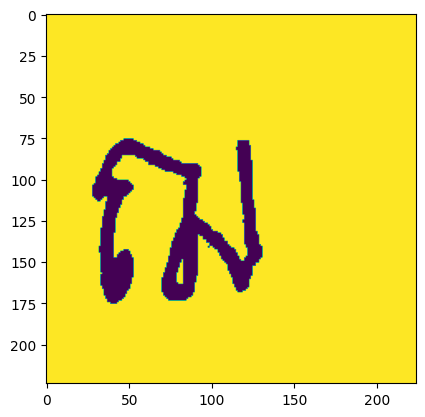

In [ ]:
plt.imshow(train_dataset[3000][0][0])
# plt.colorbar()
print(train_dataset[3000][0].shape)
print(train_dataset[3000][1])

In [ ]:
model_name = "resnet50"

In [ ]:
model = timm.create_model(model_name, in_chans=1, num_classes=len(class_names), pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [ ]:
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:
def train_one_epoch(epoch_index, acc_metrics):
    running_loss = 0.
    last_loss = 0.
    
    pbar = tqdm(train_loader, desc='Training')
    for i, data in enumerate(pbar):
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        optimizer.zero_grad()
        outputs = model(inputs) ## model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

        acc_metrics.update(outputs, labels)
        
        pbar.set_postfix({
            'train_loss': avg_loss,
            'train_acc': '{:.6f}'.format(float(acc_metrics.compute())) #* 100
        })
    
    last_loss = running_loss / len(train_loader)
            
    return last_loss

In [ ]:
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epoch_number = 0

EPOCHS = 25
best_vloss = 1_000_000.
best_vacc = 0
best_vscore = 0

device = "cuda"

train_acc = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)
val_acc = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

model.class_to_idx = image_dataset.class_to_idx

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, train_acc)

    model.train(False)
    acc = float(train_acc.compute())
    
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(tqdm(val_loader, desc='Validation')):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            
            val_acc.update(voutputs, vlabels)
            
    avg_vloss = running_vloss / (i + 1)
    vacc = float(val_acc.compute())
    print('LOSS: train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACCURACY: train {} valid {}'.format(acc, vacc))

    train_loss_list.append(avg_loss)
    train_acc_list.append(acc)
    val_loss_list.append(avg_vloss)
    val_acc_list.append(vacc)

    ## save best model
    if vacc > best_vscore:
        best_vscore = vacc
        model_path = os.path.join(save_dir, 'best_model_{}_thresh.pth'.format(model_name))
        torch.save({'arch': model_name,
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            model_path)
        print('New best model saved.')
        
    train_acc.reset()
    val_acc.reset()
    
    lr_scheduler.step(avg_vloss)
    epoch_number += 1

EPOCH 1:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.622650951744443 valid 0.2317485362291336
ACCURACY: train 0.8310173153877258 valid 0.9281484484672546
New best model saved.
EPOCH 2:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.19537272601802316 valid 0.19216091930866241
ACCURACY: train 0.9410603642463684 valid 0.9420450329780579
New best model saved.
EPOCH 3:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.14795102616489836 valid 0.20345544815063477
ACCURACY: train 0.9553906321525574 valid 0.9402289986610413
EPOCH 4:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.1237132671169203 valid 0.2505364418029785
ACCURACY: train 0.9603647589683533 valid 0.9320173859596252
EPOCH 5:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.10903796594886278 valid 0.19492605328559875
ACCURACY: train 0.9650428295135498 valid 0.9446505904197693
New best model saved.
EPOCH 6:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.09080434268848463 valid 0.1981034129858017
ACCURACY: train 0.9698787927627563 valid 0.9460718631744385
New best model saved.
EPOCH 7:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.08406544889492745 valid 0.18807891011238098
ACCURACY: train 0.9715960621833801 valid 0.9487563967704773
New best model saved.
EPOCH 8:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.07193807409247242 valid 0.21155859529972076
ACCURACY: train 0.9754846096038818 valid 0.9440979361534119
EPOCH 9:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.06222423636901305 valid 0.2188989669084549
ACCURACY: train 0.9794915318489075 valid 0.9414923191070557
EPOCH 10:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.05473766646246812 valid 0.22495774924755096
ACCURACY: train 0.9812285304069519 valid 0.9422819018363953
EPOCH 11:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.04836460355874457 valid 0.24211929738521576
ACCURACY: train 0.9837155938148499 valid 0.9402289986610413
EPOCH 12:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0430116732171184 valid 0.21981629729270935
ACCURACY: train 0.9853341579437256 valid 0.9485195279121399
EPOCH 13:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.03945408580241774 valid 0.2570584714412689
ACCURACY: train 0.9871106743812561 valid 0.9356494545936584
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
EPOCH 14:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.013325392146156207 valid 0.19554992020130157
ACCURACY: train 0.9960917234420776 valid 0.9571259617805481
New best model saved.
EPOCH 15:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.004220180469745155 valid 0.2129358947277069
ACCURACY: train 0.9992302060127258 valid 0.9573628306388855
New best model saved.
EPOCH 16:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0020699376649659052 valid 0.23306971788406372
ACCURACY: train 0.9997039437294006 valid 0.9572838544845581
EPOCH 17:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0013306998739952894 valid 0.2533041536808014
ACCURACY: train 0.9998223781585693 valid 0.9566521644592285
EPOCH 18:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0009026017342173211 valid 0.2659350633621216
ACCURACY: train 0.99984210729599 valid 0.9572838544845581
EPOCH 19:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0004936578635280709 valid 0.2818428874015808
ACCURACY: train 0.9999210238456726 valid 0.9583103060722351
New best model saved.
Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
EPOCH 20:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.00032338366805455585 valid 0.28077587485313416
ACCURACY: train 0.9999605417251587 valid 0.9583103060722351
EPOCH 21:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.00030086770309974717 valid 0.2848186790943146
ACCURACY: train 0.9999605417251587 valid 0.9590209126472473
New best model saved.
EPOCH 22:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.00025864938324176743 valid 0.28299680352211
ACCURACY: train 1.0 valid 0.9589419364929199
EPOCH 23:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.0002579852880619501 valid 0.2922675609588623
ACCURACY: train 0.9999802708625793 valid 0.9579155445098877
EPOCH 24:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.00018161563143839792 valid 0.29029881954193115
ACCURACY: train 1.0 valid 0.9578365683555603
EPOCH 25:


Training:   0%|          | 0/792 [00:00<?, ?it/s]

Validation:   0%|          | 0/198 [00:00<?, ?it/s]

LOSS: train 0.00018043215055913055 valid 0.2948533892631531
ACCURACY: train 1.0 valid 0.9579944610595703
Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.


In [ ]:
import torch.nn.functional as F

In [ ]:
model_path = "/content/models/best_model_resnet50_thresh.pth"
model_name = "resnet50"
chpt = torch.load(model_path)
model_done = timm.create_model(chpt['arch'], in_chans=1, num_classes=len(class_names), pretrained=True)
model_done.load_state_dict(chpt['state_dict'])
model_done.class_to_idx = chpt['class_to_idx']
device = "cuda"
model_done.to(device)
model_done.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
testdir = "/content/test/test/"

file_name_list = []
predict_list = []

for files in tqdm(os.listdir(testdir)):
  path = testdir+files
  sample_image = cv2.imread(path, cv2.COLOR_BGR2RGB)
  sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
  sample_image = cv2.resize(sample_image, (224,224))
  ret,sample_image = cv2.threshold(sample_image,220,255,cv2.THRESH_BINARY)
  convert_tensor = transforms.ToTensor()
  sample_image_tensor = convert_tensor(sample_image)
  sample_image_tensor = sample_image_tensor.float()
  model_input = sample_image_tensor.unsqueeze(0).to("cuda")

  # Probs
  probs = torch.exp(model_done.forward(model_input))

  # Top probs
  top_probs, top_labs = probs.topk(5)
  top_probs = top_probs.cpu().detach().numpy().tolist()[0] 
  top_labs = top_labs.cpu().detach().numpy().tolist()[0]

  idx_to_class = {val: key for key, val in model_done.class_to_idx.items()}
  top_labels = [idx_to_class[lab] for lab in top_labs]

  file_name_list.append(files)
  predict_list.append(top_labels[0])

  0%|          | 0/13599 [00:00<?, ?it/s]

In [ ]:
df_sub = pd.DataFrame()
df_sub["filename"] = file_name_list
df_sub["class"] = predict_list
df_sub.head()

,filename,class
0,9.jpg,21
1,7122.jpg,8
2,13329.jpg,43
3,6412.jpg,32
4,12498.jpg,10


In [ ]:
submission_df = pd.read_csv("/content/submission.csv")
submission_df.head()

,filename,class
0,0.jpg,28.0
1,1.jpg,8.0
2,2.jpg,9.0
3,3.jpg,NaN
4,4.jpg,NaN


In [ ]:
submission_df = submission_df.merge(df_sub, left_on='filename', right_on='filename', how="left")

In [ ]:
submission_df = submission_df.drop(columns={"class_x"})
submission_df = submission_df.rename(columns={"class_y":"class"})

In [ ]:
submission_df.to_csv("submission_df_resnet4.csv", index=False)

In [ ]:
from google.colab import files
files.download('submission_df_resnet4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>